In [3]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/9e/b8/ed5f794359d05cd0bffb894c6418da87b93016ee17b669d55c45d1bd5d5b/tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata (2.6 kB)
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/2f/2f/3c84f675931ce3bcbc7e23acbba1e5d7f05ce769adab48322de57a9f5928/tensorflow_intel-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.13.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Obtaining dependency information for h5py>=2.9.0 from https://files.pythonhosted.org/packages/d1/93/0f4cf5058095d749d464e4f770d2bf339930e5f3374331f0d2fa6ddfbf28/

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from finta import TA
import yfinance as yf

In [5]:
# Define the ticker symbols
#tickerSymbols = ['AAPL', 'AMZN', 'MSFT']

# Initialize a dictionary to hold all dataframes
dict_of_df = {}

#for ticker in tickerSymbols:
# Get data on this ticker
tickerData = yf.Ticker('AAPL')

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', interval='15m', start='2023-6-1', end='2023-7-18')

In [6]:
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-06-01 09:30:00-04:00,177.699997,177.865005,176.949997,177.509995,4612639,0.0,0.0
2023-06-01 09:45:00-04:00,177.509995,177.690002,176.930603,177.309998,2545624,0.0,0.0
2023-06-01 10:00:00-04:00,177.320007,178.250000,177.279999,178.229996,2342355,0.0,0.0
2023-06-01 10:15:00-04:00,178.229996,178.360001,177.714996,178.100006,2238735,0.0,0.0
2023-06-01 10:30:00-04:00,178.110001,178.990005,178.000000,178.970001,2130895,0.0,0.0
...,...,...,...,...,...,...,...
2023-07-17 14:45:00-04:00,193.649902,193.800003,193.619995,193.678802,809679,0.0,0.0
2023-07-17 15:00:00-04:00,193.679993,193.929993,193.669998,193.804993,1250414,0.0,0.0
2023-07-17 15:15:00-04:00,193.800003,194.320007,193.759995,194.149994,2449011,0.0,0.0


In [21]:
tickerDf['14SMA'] = TA.SMA(tickerDf, 14)
tickerDf['14EMA'] = TA.EMA(tickerDf, 14)
tickerDf['7SMA'] = TA.SMA(tickerDf, 7)
tickerDf['7EMA'] = TA.EMA(tickerDf, 7)
tickerDf['RSI'] = TA.RSI(tickerDf)
tickerDf['MACD'] = TA.MACD(tickerDf)['MACD'] - TA.MACD(tickerDf)['SIGNAL']
tickerDf.dropna(inplace=True)

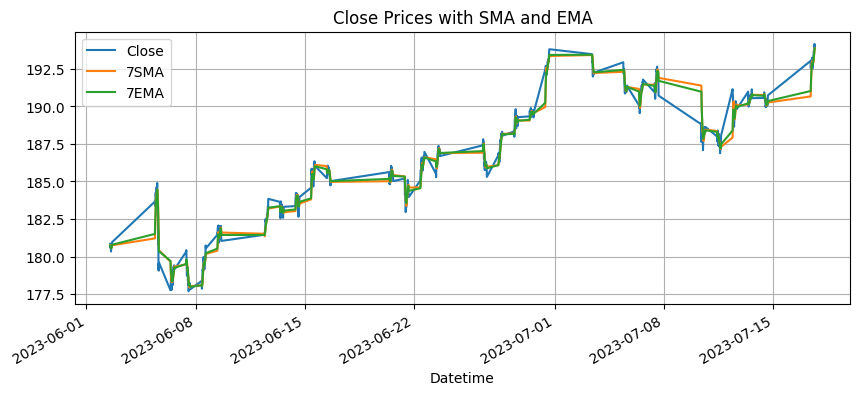

In [22]:
# Visualize data
tickerDf[['Close', '7SMA', '7EMA']].plot(figsize=(10,4))
plt.grid(True)
plt.title('Close Prices with SMA and EMA')
plt.show()

In [23]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tickerDf.values)

# Split the data into training and test sets
train_length = int(len(scaled_data) * 0.9)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length, :]
test_data = scaled_data[train_length - 60:, :]

# Prepare data for LSTM
x_train, y_train, x_test, y_test = [], [], [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i])
    y_test.append(test_data[i, 0])

x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], scaled_data.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], scaled_data.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [24]:
# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/20
20/20 [==============================] - 3s 28ms/step - loss: 0.0665
Epoch 2/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0111
Epoch 3/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0081
Epoch 4/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0070
Epoch 5/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0065
Epoch 6/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0052
Epoch 7/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0051
Epoch 8/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0054
Epoch 9/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0045
Epoch 10/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0047
Epoch 11/20
20/20 [==============================] - 1s 27ms/step - loss: 0.0040
Epoch 12/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0041
Epoch 13/20
20/20 [==================

In [26]:
import math
# Make predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Create a scaler for 'Close' price only
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit_transform(tickerDf['Close'].values.reshape(-1,1))

# Invert 'Close' price predictions
train_predict_rescaled = close_scaler.inverse_transform(train_predict)
y_train_rescaled = close_scaler.inverse_transform(y_train.reshape(-1,1))
test_predict_rescaled = close_scaler.inverse_transform(test_predict)
y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1,1))


# Plotting the prices vs predicted values
plt.figure(figsize=(16,8))

# Training set
plt.subplot(1, 2, 1)
plt.plot(y_train_rescaled, color='blue', label='Real')
plt.plot(train_predict_rescaled[:,0], color='red', label='Predicted')
plt.title('Price Prediction - Training Set')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Test set
plt.subplot(1, 2, 2)
plt.plot(y_test_rescaled, color='blue', label='Real')
plt.plot(test_predict_rescaled[:,0], color='red', label='Predicted')
plt.title('Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.show()


3/3 [==============================] - 0s 9ms/step


ValueError: non-broadcastable output operand with shape (619,1) doesn't match the broadcast shape (619,15)